<a href="https://colab.research.google.com/github/rafaeldsouza/mestrado/blob/main/Redes%20Neurais/Atividade2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implemente uma Rede Neural rasa para classificação de uma base multiclasse.

Esta rede deve:

Aceitar rótulos que podem ser números ou textos;

Predizer os rótulos originais da base de dados;

Passar por parâmetro no construtor:

Função de custo e cálculo do gradiente;

Taxa de aprendizado;

Número máximo de iterações;

Threshold;

Funcionar para bases binárias.

Teste pelo menos duas funções de custo diferentes em uma base multiclasse e uma base binária.

Plote gráficos com os hiperplanos separadores encontrados pelos algoritmos de treinamento. Se a base escolhida tiver mais do que 2 características, escolha as que você julgar que fornecem a melhor visualização.


In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.special import expit
from abc import ABC, abstractstaticmethod
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize
from abc import ABC, abstractmethod



def criaDataset(n=1000, nclasses = 4):
  x,y = make_blobs(n_samples=n, centers=nclasses, center_box=(0,1), cluster_std=0.02)
  return x,y

In [2]:
def plotadataset(X, y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)


def plotaHiperplano(X, y, vetor, intercept=0):
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    xs = np.linspace(x0min, x0max, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - intercept / vetor[1]
    plt.plot(xs,ys)


In [3]:
def sign(a):
    return (a >= 0) * 2 - 1

    
class custo(ABC):
  @abstractstaticmethod
  def custo(y,ypred):
    pass
  @abstractstaticmethod
  def gradiente(y,ypred):
    pass

class WidrowHoff(custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum((y-ypred)**2)
  @staticmethod
  def gradiente(y,ypred):
    return y-ypred

class SmoothedSurrogate(custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum(np.maximum(np.zeros(y.shape),-y*ypred))

  @staticmethod
  def gradiente(y,ypred):
    return y-sign(ypred)

class LogLikehood(custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.log(1 + np.exp(-y * ypred)))
    
    @staticmethod
    def gradiente(y, ypred):
        return y - (expit(ypred)*2-1)

In [4]:

class Perceptron(BaseEstimator, ClassifierMixin):
    def encode_labels(self,y):
      self.labels = list(set(y))
      return label_binarize(y, classes=self.labels)*2-1

    def __init__(self, training_algorithm):
        self.w = None
        self.activation = sign
        self.training_algorithm = training_algorithm
    
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb

    def fit(self, X, y):
        yhot = self.encode_labels(y)
        Xb = Perceptron.includebias(X)
        self.w = self.training_algorithm.getW(Xb, yhot)
    
    def __pre_activation(self, X):
        Xb = Perceptron.includebias(X)
        return Xb @ self.w

    def predict(self, X):
        a = self.__pre_activation(X)
        if self.w.shape[1]==1:
          idx=np.array(a>0,dtype=int).reshape((-1,))
        else:
          idx = np.argmax(a,axis=1)
        ypred=np.array([self.labels[i] for i in idx])
        return ypred

In [5]:
class TrainingAlgorithm(ABC):
    @abstractmethod
    def getW(self, X, y):
        pass

class PseudoInversa(TrainingAlgorithm):
    def getW(self, X, y):
        return np.linalg.pinv(X) @ y

class DescidaGradiente(TrainingAlgorithm):
    def __init__(self,max_iter=1000,learning_rate=0.02,regularization=0,cost=WidrowHoff()):
      self.max_iter = max_iter
      self.learning_rate = learning_rate
      self.regularization = regularization
      self.cost = cost

    def getW(self, X, y):
        w = np.random.uniform(-1, 1, size=(X.shape[1], y.shape[1]))
        for _ in range(self.max_iter):
            ypred = X @ w
            if self.cost.custo(y, ypred) == 0:
                break
            w *= 1-self.learning_rate*self.regularization
            w += (X.T @ self.cost.gradiente(y,ypred)) * self.learning_rate 
        return w

##Binario

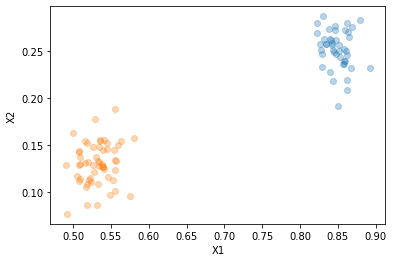

In [39]:
X,y = criaDataset(nclasses=2)
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.9)
plotadataset(Xtr,ytr)

### WidrowHoff

1.0
[[ 4.02603029]
 [-5.128745  ]
 [-2.52505791]]


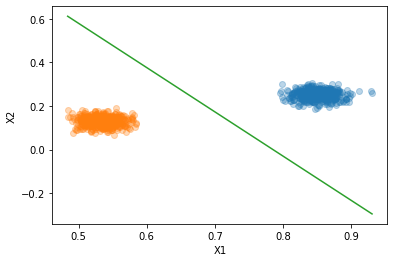

In [44]:
descida = DescidaGradiente(cost=WidrowHoff(),max_iter=200,learning_rate=0.01)
perceptron = Perceptron(descida)

perceptron.fit(Xtr,ytr)
ypred = perceptron.predict(Xte)
print(sum(ypred == yte)/len(ypred))
print(perceptron.w)
plotadataset(X,y)

for i in range(perceptron.w.shape[1]):
        plotaHiperplano(X,y, perceptron.w[1:,i], perceptron.w[0,i])

###LogLikehood

1.0
[[  7.98058327]
 [-10.0206624 ]
 [ -5.27056382]]


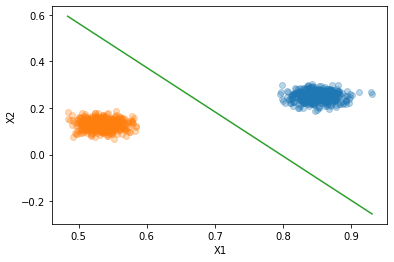

In [45]:
descida = DescidaGradiente(cost=LogLikehood(),max_iter=100,learning_rate=0.02)
perceptron = Perceptron(descida)


perceptron.fit(Xtr,ytr)
ypred = perceptron.predict(Xte)
print(sum(ypred == yte)/len(ypred))
print(perceptron.w)
plotadataset(X,y)

for i in range(perceptron.w.shape[1]):
        plotaHiperplano(X,y, perceptron.w[1:,i], perceptron.w[0,i])

## Multiclasse

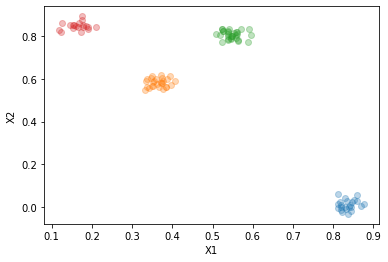

In [67]:
X,y = criaDataset(nclasses=4)
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.9)
plotadataset(Xtr,ytr)

### WidrowHoff

1.0
[[-0.03643618  0.53450856 -2.70438038 -0.01900176]
 [ 1.08951891 -1.42348109  2.18445423 -1.59497704]
 [-1.82919238 -0.54239154  2.2444508   0.29795089]]


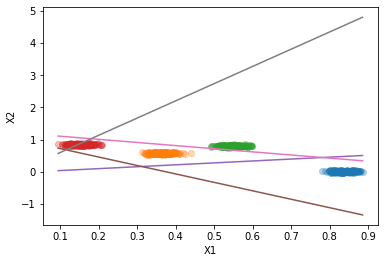

In [72]:
descida = DescidaGradiente(cost=WidrowHoff(),max_iter=50,learning_rate=0.01)
perceptron = Perceptron(descida)

perceptron.fit(Xtr,ytr)
ypred = perceptron.predict(Xte)
print(sum(ypred == yte)/len(ypred))
print(perceptron.w)
plotadataset(X,y)

for i in range(perceptron.w.shape[1]):
        plotaHiperplano(X,y, perceptron.w[1:,i], perceptron.w[0,i])

###LogLikehood

1.0
[[-0.177602    1.68223498 -6.80022587 -1.12457742]
 [ 3.91692654 -3.88557299  5.10575208 -8.65196262]
 [-8.1614547  -1.55362819  5.84867745  4.06846339]]


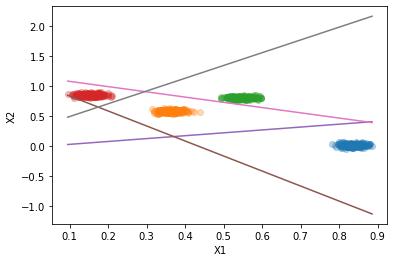

In [73]:
descida = DescidaGradiente(cost=LogLikehood(),max_iter=50,learning_rate=0.03)
perceptron = Perceptron(descida)

perceptron.fit(Xtr,ytr)
ypred = perceptron.predict(Xte)
print(sum(ypred == yte)/len(ypred))
print(perceptron.w)
plotadataset(X,y)

for i in range(perceptron.w.shape[1]):
        plotaHiperplano(X,y, perceptron.w[1:,i], perceptron.w[0,i])

